   Year   SCL          Species
0  1982  75.9  Caretta caretta
1  1982  76.9  Caretta caretta
2  1982  78.2  Caretta caretta
3  1982  78.7  Caretta caretta
4  1982  79.1  Caretta caretta


<AxesSubplot:xlabel='SCL', ylabel='Count'>

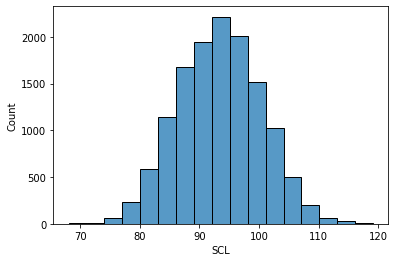

In [234]:
import pandas as pd
turtles_data = pd.read_csv("turtles_data.csv")
#view head of data
print(turtles_data.head(5))

#what is the overall distribution of straight carapace length for both species?
import seaborn as sns
sns.histplot(data=turtles_data, x="SCL", binwidth=3)

The mean straight carapace lengths for the two turtle species are: Species
Caretta caretta    91.117139
Chelonia mydas     99.780682
Name: SCL, dtype: float64


<AxesSubplot:xlabel='Year', ylabel='SCL Average'>

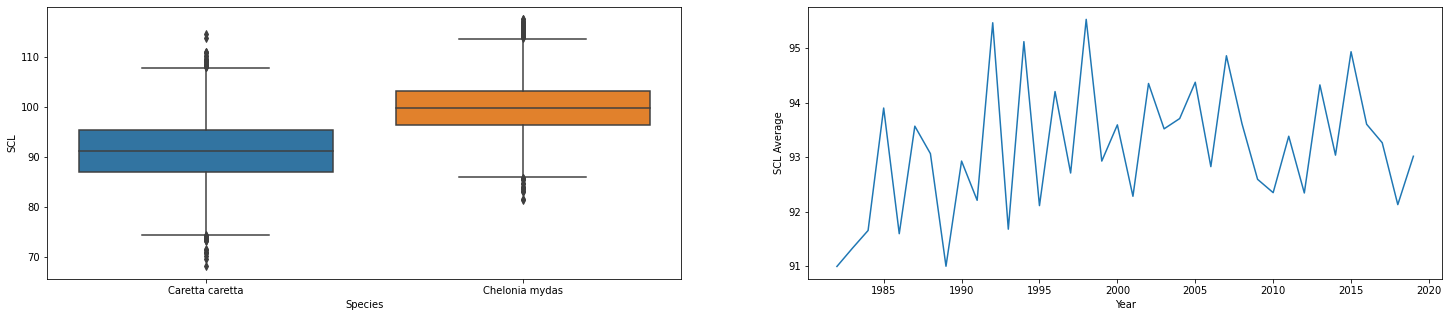

In [235]:
#what are the mean SCL (straight carapace) lengths for the sea turtles based only on species?
mean_SCL_species = turtles_data.groupby(['Species'])['SCL'].mean()
print("The mean straight carapace lengths for the two turtle species are:", mean_SCL_species)
fig, axes = plt.subplots(1, 2, figsize = (25, 5))
#a boxplot for straight carapace lengths based on species, not including year
sns.boxplot(x='Species', y='SCL', data=turtles_data, ax=axes[0])

#what are the mean SCL (straight carapace) lengths for the sea turtles based only on year
turtles_data['Year'] = turtles_data['Year'].astype("category")
only_year = turtles_data.groupby(['Year'])['SCL'].mean()
only_year = only_year.reset_index()
only_year.columns = ['Year', 'SCL Average']
sns.lineplot(x='Year', y='SCL Average', data=only_year, ax=axes[1])

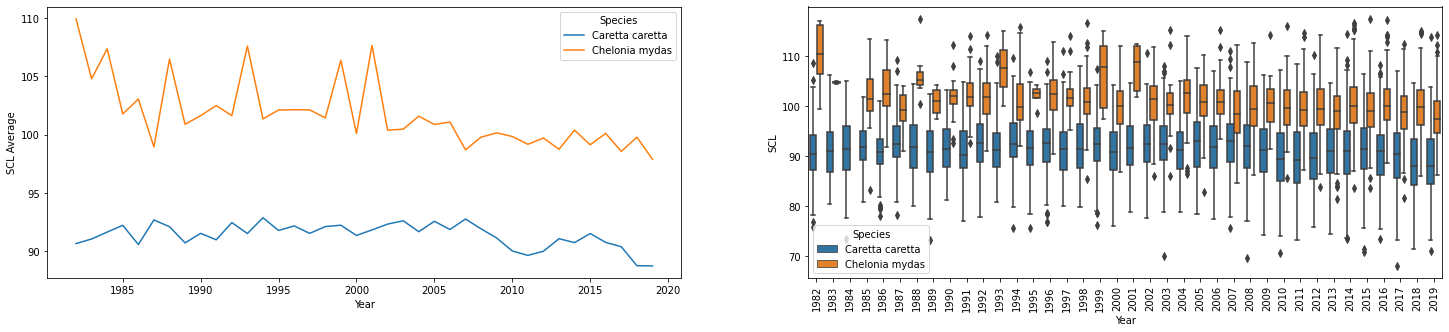

In [236]:

#what are the mean SCLs for the sea turtles based on both year and species?
mean_SCL_both = turtles_data.groupby(['Year', 'Species'])['SCL'].mean()
mean_SCL_both = pd.DataFrame(mean_SCL_both)
mean_SCL_both = mean_SCL_both.unstack()
mean_SCL_both.columns = mean_SCL_both.columns.get_level_values(1)
mean_SCL_both.columns.name = ''
mean_SCL_both.reset_index(level=0, inplace=True)
#fill in our missing value in 1984 with the mean of the two previous years
mean_1982_1983_Chelonia_mydas = mean_SCL_both.loc[mean_SCL_both['Year'].isin([1982, 1983])]
mean_1982_1983_Chelonia_mydas = mean_1982_1983_Chelonia_mydas['Chelonia mydas']
missing_value = mean_1982_1983_Chelonia_mydas.values.mean()
mean_SCL_both['Chelonia mydas'] = mean_SCL_both['Chelonia mydas'].fillna(missing_value)
#melt the data
mean_SCL_both = pd.melt(mean_SCL_both, id_vars='Year', value_vars=['Caretta caretta', 'Chelonia mydas'], 
                                                                   var_name='Species', value_name='SCL Average')
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize = (25, 5))
#plot with x as year, y=mean SCL, two lines=species
sns.lineplot(x='Year', y='SCL Average', hue = 'Species', data=mean_SCL_both, ax=axes[0])
#alternatively, a boxplot for each year, with the hue=Species
sns.boxplot(x='Year', y='SCL', hue='Species', data=turtles_data, ax=axes[1])
axes[1].tick_params(axis='x', rotation=90)

    Year         Species  SCL Average
38  1982  Chelonia mydas   109.940000
49  1993  Chelonia mydas   107.600000
57  2001  Chelonia mydas   107.666667


Text(0.5, 1.0, 'Chelonia mydas')

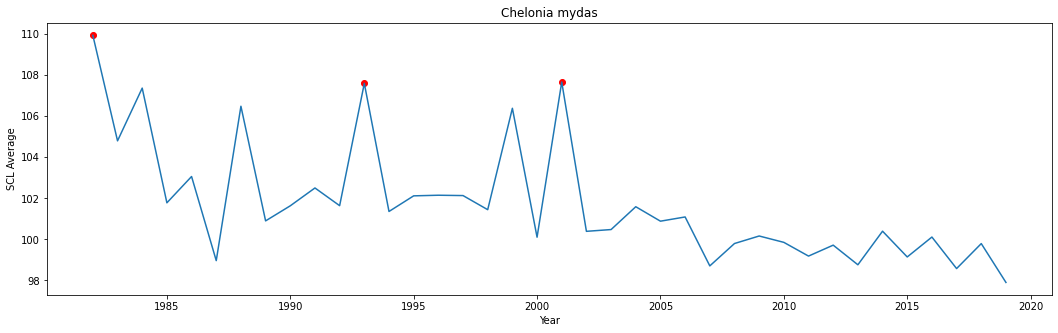

In [155]:
from scipy import stats
import numpy as np
#it looks like there are several spikes in the mean SCL for Chelonia mydas - what years would be considered spikes?
#subset to only include 'Chelonia mydas'
mean_SCL_Chelonia_mydas = mean_SCL_both[mean_SCL_both['Species'] == 'Chelonia mydas']
z_score = np.abs(stats.zscore(mean_SCL_Chelonia_mydas['SCL Average']))
#then, df.ix[ind_list]
outlier_index = [ index for index, number in enumerate(z_score) if number > 2]
#identify years of outliers
years_outliers = mean_SCL_Chelonia_mydas.iloc[outlier_index]
print(years_outliers)
#replot only mean SCL for 'Chelonia mydas' with outliers included in red
years = years_outliers['Year'].values.tolist()
outliers = years_outliers['SCL Average'].values.tolist()
import matplotlib.pyplot as plt
plt.figure(figsize = (18, 5))
plt.plot(mean_SCL_Chelonia_mydas['Year'], mean_SCL_Chelonia_mydas['SCL Average'])
for i in list(range(len(years))):
    plt.scatter(years[i], outliers[i], color = 'red')
plt.xlabel("Year")
plt.ylabel("SCL Average")
plt.title("Chelonia mydas")

KNeighbors model score: 0.82


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['Caretta caretta', 'Chelonia mydas'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


RandomForest model score: 0.8


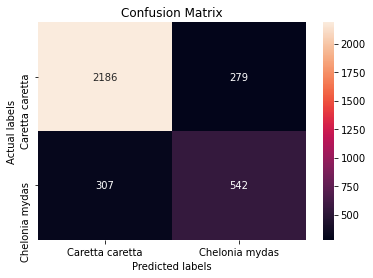

In [232]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

X = turtles_data[['Year', 'SCL']]
y = turtles_data['Species']
#plt.scatter(turtles_data['Year'], turtles_data['SCL'], c = turtles_data['Species'])
x_train, x_test, y_train, y_test = train_test_split(X, y)
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
print("KNeighbors model score:", round(knn.score(x_test, y_test), 2))

predictions = list(knn.predict(x_test))
actual = list(y_test)
  
#plot confusion matrix
labels = ['Caretta caretta', 'Chelonia mydas']
cm = confusion_matrix(actual, predictions, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax) 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
print("RandomForest model score:", round(rf.score(x_test, y_test), 2))


In [233]:
#try model again, this time testing out a different number of neighbors
grid_params = {'n_neighbors': [3, 5, 7, 9]}
gs = GridSearchCV(KNeighborsClassifier(), grid_params)
gs_final = gs.fit(x_train, y_train)
print("Best number of neighbors:", gs_final.best_params_)

#refit our model with the best params, in this case 9
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(x_train, y_train)
print("KNeighbors model score with new neighbors:", round(knn.score(x_test, y_test), 2))


#try using feature transformation - scaling the SCL between 0 and 1, and using more data for training - 0.85 
#instead of 0.75 for training, so split will be 0.85/0.15 between training and testing
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
scaled_SCL = scaler.fit_transform(x_train['SCL'].values.reshape(-1, 1)).tolist()
scaled_SCL_list = []
for l in scaled_SCL:
    for i in l:
        scaled_SCL_list.append(i)
x_train['SCL'] = scaled_SCL_list

#scale the x_test_SCL
scaled_SCL_x_test = scaler.fit_transform(x_test['SCL'].values.reshape(-1, 1)).tolist()
scaled_SCL_list = []
for l in scaled_SCL_x_test:
    for i in l:
        scaled_SCL_list.append(i)
x_test['SCL'] = scaled_SCL_list

knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(x_train, y_train)
print("KNeighbors model score with scaled data and new neighbors:", round(knn.score(x_test, y_test), 2))



Best number of neighbors: {'n_neighbors': 7}
KNeighbors model score with new neighbors: 0.83


<ipython-input-233-369965d94fa3>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['SCL'] = scaled_SCL_list
<ipython-input-233-369965d94fa3>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['SCL'] = scaled_SCL_list


KNeighbors model score with scaled data and new neighbors: 0.83
RandomForestClassifier model score with scaled data: 0.83
